In [1]:
from pathlib import Path
import skimage.io as skio
import numpy as np
import datetime
import json
import os
import re
import fnmatch
from PIL import Image
from pycococreatortools import pycococreatortools
import cropmask.misc as misc
from shutil import copyfile
from cropmask.coco_convert import split_save_train_test_df, path_df_to_coco_json
from cropmask.misc import parse_yaml, make_dirs
import pandas as pd
import solaris as sol

param_path = "/home/ryan/work/CropMask_RCNN/test_inspection_config.yaml"
params = parse_yaml(param_path)
tiles_path = Path(os.path.join(params['dirs']['root'], params['dirs']['dataset'], "tiles"))

/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/pyt

In [2]:
train, test = split_save_train_test_df(tiles_path, save_empty_tiles=False)
coco_path = Path(params['dirs']['root']) / params['dirs']['dataset'] / "coco"

In [3]:
def create_coco_dataset(df):
    """
    Takes a df with paths to images and geojson tiles and creates coco formatted json for training or testing.
    """
    img_lst = df['image_tiles'].to_list()
    geojson_lst = df['geojson_tiles'].to_list()
    # crazy regex is based on appending scene ID to each tile, including path/row and date info
    coco_dict = sol.data.coco.geojson2coco(image_src = [str(i) for i in img_lst],
                                       label_src = [str(i) for i in geojson_lst],
                                       matching_re=r'(\d{6}_\d{8}_\d{8}_C\d{2}_V\d_-?\d+_\d+)',
                                       license_dict={'CC-BY 4.0': 'https://creativecommons.org/licenses/by/4.0/'},
                                       remove_all_multipolygons = True,
                                       verbose=0)
    return coco_dict

In [4]:
train_coco_dict = create_coco_dataset(train)
test_coco_dict = create_coco_dataset(test)

100%|██████████| 33/33 [00:02<00:00, 12.53it/s]


In [5]:
from cropmask.coco_convert import save_coco_annotation
from detectron2.data.datasets import register_coco_instances, load_coco_json
train_coco_instances_path = str(coco_path / "instances_train.json")
test_coco_instances_path = str(coco_path / "instances_test.json")
save_coco_annotation(train_coco_instances_path, train_coco_dict)
save_coco_annotation(test_coco_instances_path, test_coco_dict)
register_coco_instances("train_nirrg", {}, train_coco_instances_path, str(next(tiles_path.glob("*image*"))))
register_coco_instances("test_nirrg", {}, test_coco_instances_path, str(next(tiles_path.glob("*image*"))))

instances_train.json saved.
instances_test.json saved.


In [6]:
train_json = load_coco_json(train_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
test_json = load_coco_json(test_coco_instances_path,  str(next(tiles_path.glob("*image*"))))

In [7]:
def max_norm_channels(arr):
    """
    arr must be of shape (w, h, channel)
    """
    arr = arr.copy()
    maxes = np.nanmax(arr, axis=(0,1))
    return arr / maxes

/datadrive/test-ard-june-sept-nirrg/tiles/image_tiles/LT05_CU_013008_20050828_20190107_C01_V0_-584865_2056965.tif
/datadrive/test-ard-june-sept-nirrg/tiles/image_tiles/LT05_CU_015008_20050915_20190102_C01_V0_-300225_2010885.tif
/datadrive/test-ard-june-sept-nirrg/tiles/image_tiles/LT05_CU_016009_20050620_20190102_C01_V0_-134865_1948511.tif
/datadrive/test-ard-june-sept-nirrg/tiles/image_tiles/LT05_CU_015009_20050908_20190102_C01_V0_-238785_1934999.tif
/datadrive/test-ard-june-sept-nirrg/tiles/image_tiles/LT05_CU_014008_20050805_20181227_C01_V0_-450225_2056965.tif


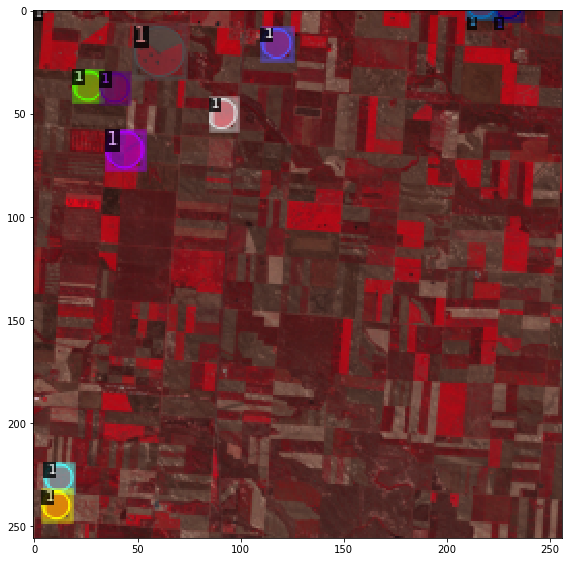

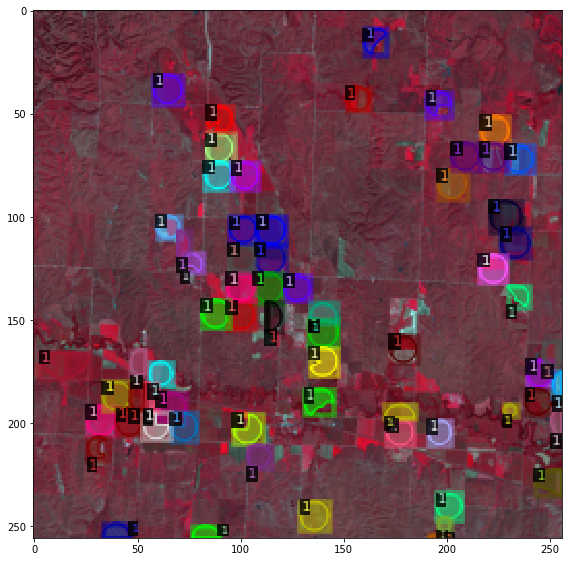

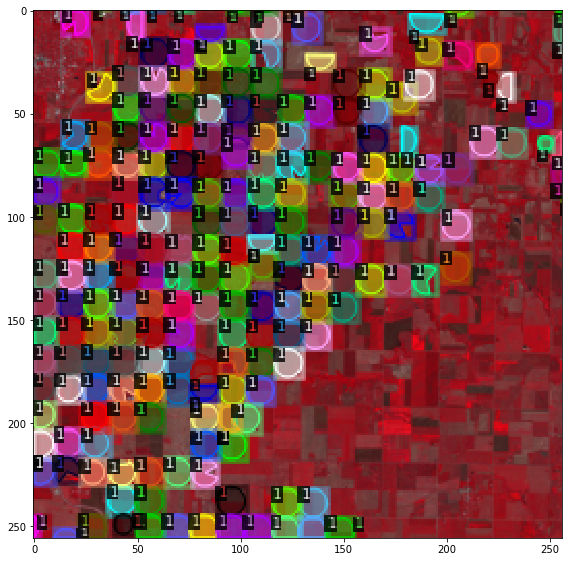

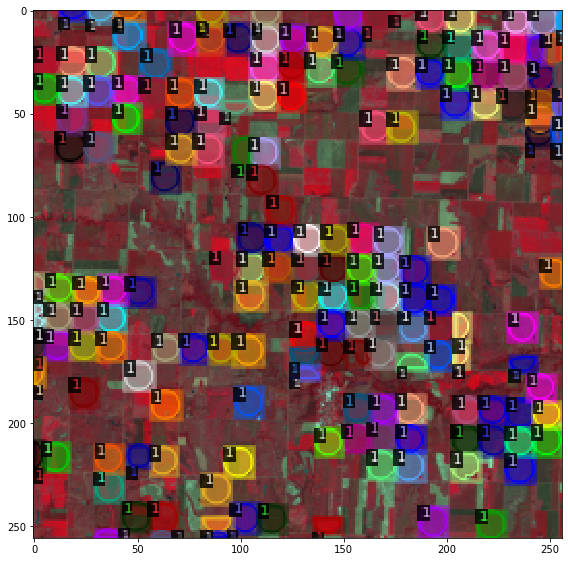

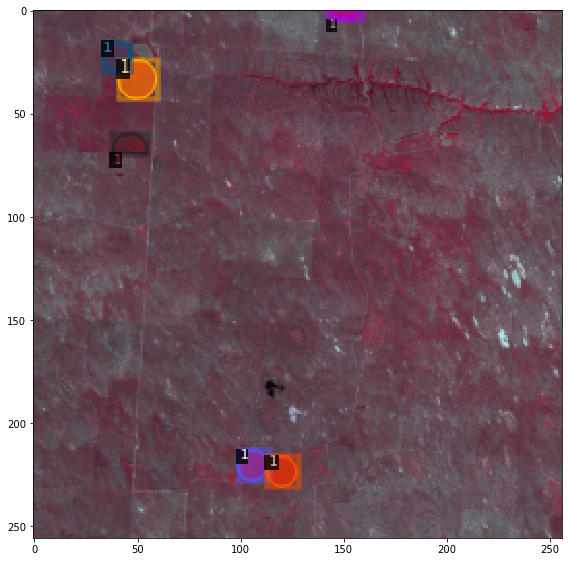

In [8]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from skimage.io import imshow, imread
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from cropmask.misc import max_normalize, percentile_rescale

for d in random.sample(train_json, 5):
    if len(d['annotations']) > 0:
        img = imread(d["file_name"])
        print(d["file_name"])
        img = img[:, :, ::-1]
        normalized = max_norm_channels(np.where(img < 0, 0, img))
        rescaled = rescale_intensity(normalized, out_range=(0,255))
        masked = np.where(rescaled==0, np.nan, rescaled)
        visualizer = Visualizer(masked, metadata={}, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (8,16))
        imshow(vis.get_image())

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_nirrg",)
cfg.DATASETS.TEST = ("test_nirrg",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # this is the default
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

# Profiling/Debugging raster tiler and filling nan values with means

In [50]:
scene_path = list(Path("/datadrive/test-ard-june-sept-nirrg/scene").glob("LT05_CU_*"))[3]

In [51]:
scene_path

PosixPath('/datadrive/test-ard-june-sept-nirrg/scene/LT05_CU_016008_20050620_20190102_C01_V0.tif')

In [24]:
import xarray 
import rioxarray
xarr = xarray.open_rasterio(scene_path)

xarr = xarr.transpose("y", "x", "band")

xarr = xarr.where(xarr != -9999.0)/32767

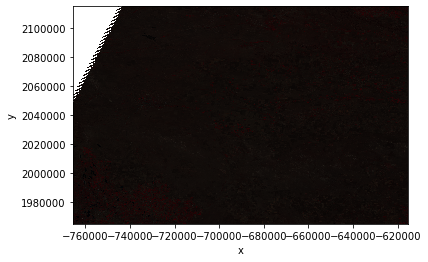

In [25]:
np.flip(xarr, axis=-1).plot.imshow()

In [26]:
import us
from cropmask import io_utils
import xarray
import rioxarray
nebraska_url = us.states.NE.shapefile_urls('state')
gdf = io_utils.zipped_shp_url_to_gdf (nebraska_url)
crs=xarray.open_rasterio(scene_path).rio.crs
bounds_poly = gdf.to_crs(crs)['geometry'].iloc[0]

/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [27]:
from solaris.utils.core import _check_crs, _check_rasterio_im_load

In [28]:
src = _check_rasterio_im_load(str(scene_path))

In [29]:
from shapely.geometry import box
mask_geometry = bounds_poly.intersection(box(*src.bounds)) # prevents enlarging raster to size of aoi_boundary

In [32]:
from rasterio.mask import mask as rasterio_mask
import rasterio

In [33]:
arr, transform = rasterio_mask(src, [mask_geometry], all_touched=False, invert=False, nodata=src.meta['nodata'], filled=True, crop=False, pad=False, pad_width=0.5, indexes=[1,2,3])

with rasterio.open("/datadrive/tmp-masked.tif", 'w', **src.profile) as dest:
    dest.write(arr)
    dest.close()
src = _check_rasterio_im_load("/datadrive/tmp-masked.tif")

In [53]:
arr, transform = rasterio_mask(src, [mask_geometry], all_touched=False, invert=False, nodata=src.meta['nodata'], filled=False, crop=False, pad=False, pad_width=0.5, indexes=[1,2,3])

In [72]:
def fill_by_mean(arr):
    """
    Fills a masked array of shape (channel, H, W) by the channel means of the whole array for each channel.
    This is used to fill the channel means of the image that is tiled if fill_by_mean=True.
    """
    means = arr.mean(axis=(1,2))
    arr.soften_mask()
    for i,mean in enumerate(means):
        arr[i][arr.mask[i]==True] = mean


In [68]:
arr.soften_mask()
arr[0][0] = np.ma.masked

In [79]:
arr[1]

masked_array(
  data=[[1317, 1317, 1317, ..., 1217, 1287, 1181],
        [1317, 1317, 1317, ..., 1252, 1357, 1252],
        [1317, 1317, 1317, ..., 1181, 1357, 1357],
        ...,
        [1317, 1317, 1317, ..., 1317, 1317, 1317],
        [1317, 1317, 1317, ..., 1317, 1317, 1317],
        [1317, 1317, 1317, ..., 1317, 1317, 1317]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-9999,
  dtype=int16)

In [77]:
means[1]

1317.939922309107

In [34]:
src.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 5000, 'height': 5000, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_IAU_1976_ellipsoid",SPHEROID["IAU 1976",6378140,298.257]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -765585.0,
       0.0, -30.0, 2114805.0), 'tiled': False, 'interleave': 'pixel'}

In [35]:
tile_path = '/datadrive/test-ard-june-sept-nirrg/tiles/image_tiles/LT05_CU_013009_20050711_20190102_C01_V0_-511746_1962203.tif'

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


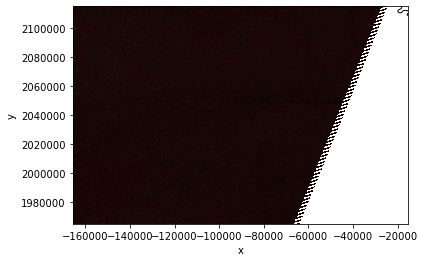

In [52]:
fig, ax = plt.subplots()
xarr = xarray.open_rasterio(scene_path)

xarr = xarr.transpose("y", "x", "band")

xarr = xarr.where(xarr != -9999.0)/32767


gpd.GeoDataFrame(geometry=[bounds_poly]).plot(ax=ax, color=None,edgecolor='k', facecolor="none")
np.flip(xarr, axis=-1).plot.imshow(ax=ax)

In [40]:
from shapely.ops import cascaded_union
from shapely.geometry import box
total_shape = cascaded_union([box(*i) for i in raster_tiler.tile_bounds])

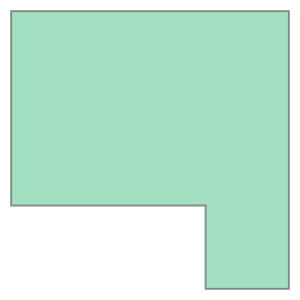

In [44]:
total_shape

In [42]:
raster_bounds_crs = raster_tiler.tile(str(scene_path))

0it [00:00, ?it/s]The following warnings were found:
- The file is greater than 512xH or 512xW, it is recommended to include internal overviews

The following errors were found:
- The file is greater than 512xH or 512xW, but is not tiled


Beginning tiling...
Checking input data...
COG: False
[1, 2, 3]
Source CRS: EPSG:None
Destination CRS: EPSG:None
Inputs OK.


79it [00:04, 18.19it/s]

Tiling complete. Cleaning up...
Done. CRS returned for vector tiling.


In [43]:
if isinstance(bounds_poly, str):
    gj = json.loads(open(geometry).read())

    features = gj['features']
    if not len(features) == 1:
        print('Feature collection must only contain one feature')
        sys.exit(1)

    geometry = shape(features[0]['geometry'])

elif isinstance(geometry, list) or isinstance(geometry, np.ndarray):
    assert len(geometry) == 4
    geometry = box(*geometry)

NameError: name 'geometry' is not defined

In [ ]:
# sample_g = geojson_lst[0:5]

# sample_g = sample_g[::-1]

# sample_i = img_lst[0:5]

# gdf = gpd.read_file(geojson_lst[183])

# from solaris.vector.polygon import remove_multipolygons

# gdf['geometry'][0]

# remove_multipolygons(gdf).reset_index(drop=True)

# remove_multipolygons(gdf)['geometry'][0]

# import geopandas as gpd
# gpd.read_file(geojson_lst[183])['geometry'][0]